# Factors that might contribute to No Show Appointment
## by Oluwatosin Durodola

## Investigation Overview

In this investigation, I waited to look at some features that could be used to predict patients from not showing up for their appointment. The main focus was on waiting days (schedule date to appointment date) and age.


## Dataset Overview

There are 110,527 patients in the dataset with 17 features (the actual 14 features - `patientid`, `appointmentid`, `gender`, `schedule_date`, `appointment_date`, `age`, `neighbourhood`, `scholarship`, `hypertension`, `diabetes`, `alcoholism`, `handicap`, `sms_received`, `no_show`and additional 3 features created by me - `waiting days`, `appointment_day`, and `age_group`). Six data points were removed from the analysis due to inconsistencies or missing information.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
no_show_app = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [3]:
# Data wrangling

# convert patientid and appointmentid to str instead of float and int recpectively since they are just meant for identification
no_show_app['PatientId'] = no_show_app['PatientId'].astype('int64').astype(str).str.zfill(15)

no_show_app['AppointmentID'] = no_show_app['AppointmentID'].astype(str)

In [4]:
# convert scheduled_date and appointment_date to datetime instead of string
date_columns = ['ScheduledDay', 'AppointmentDay']

for date_column in date_columns:
    no_show_app[date_column] = pd.to_datetime(no_show_app[date_column]).dt.date.astype('datetime64[ns]')

In [5]:
# rename misspelled columns and change all columns to lowercase for consistence
# also interchange sms received and handicap (handicap can't have a value more than 0 and 1 i.e. No and Yes)
no_show_app.rename(columns = {'ScheduledDay':'Scheduled_Date', 'AppointmentDay':'Appointment_Date',
                              'Hipertension':'Hypertension','SMS_received':'Handicap', 'Handcap':'SMS_received',
                              'No-show':'No_show'}, inplace=True)

no_show_app.rename(columns= lambda x: x.lower(), inplace=True)

In [6]:
# convert gender, scholarship, hypertension, diabetes, alcoholism, handicap, and no_show into categorical types
nominal_var_dict = {'gender': ['M','F'],
                    'scholarship': [0, 1],
                    'hypertension': [0, 1],
                    'diabetes': [0, 1],
                    'alcoholism': [0, 1],
                    'handicap': [0, 1],
                    'no_show': ['No', 'Yes']}

for var in nominal_var_dict:
    nominal_var = pd.api.types.CategoricalDtype(categories = nominal_var_dict[var])
    no_show_app[var] = no_show_app[var].astype(nominal_var)

In [7]:
# create a new column appointment day of the week to help in my investigation
no_show_app['appointment_day'] = pd.to_datetime(no_show_app['appointment_date']).dt.day_name()


dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
days = pd.api.types.CategoricalDtype(categories=dow, ordered=True)
no_show_app['appointment_day'] = no_show_app['appointment_day'].astype(days)

In [8]:
# Create another column for waiting days (appointment_date - schedule_date)
no_show_app['waiting_days'] = no_show_app['appointment_date'] - no_show_app['scheduled_date']

no_show_app['waiting_days'] = no_show_app['waiting_days'].dt.days

In [9]:
#this bin egdes will be used to cut the data into groups
bin_edges = [-1, 5, 12, 18, 40, 60, 115]

#label for the age group
bin_names = ['Early Childhood', 'Middle Childhood', 'Adolescence', 'Youthhood', 'Middle Age', 'Old Age']

no_show_app['age_group'] = pd.cut(no_show_app['age'], bin_edges, labels=bin_names, ordered=True)

In [10]:
# drop negative value of age and waiting days columns, then reset and drop index
no_show_app = no_show_app[(no_show_app['age'] >= 0) & (no_show_app['waiting_days'] >= 0)]
no_show_app = no_show_app.reset_index(drop=True)

## Frequency of Patients who showed up or not

The No show variable in the dataset is a question that take on a Yes or No value to answer if the patient showed up or not; the `Yes` value represent the patient who missed or didn't show up for their appointment while the `No` value represent the patient who showed up for their appointment. There are about 80% (88,207) out of over 110,521 patients who showed up for their appointment while the remaining 20% (22,314) didn't.

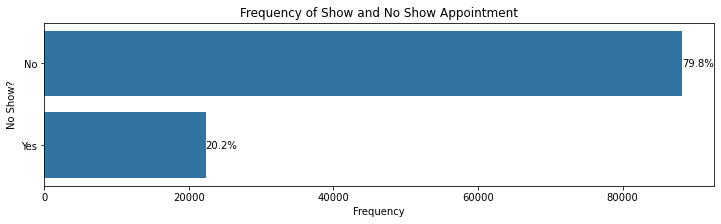

In [11]:
plt.figure(figsize=[12, 3])
base_color = sb.color_palette()[0]

no_show_counts = no_show_app['no_show'].value_counts()
no_show_order = no_show_app['no_show'].value_counts().index
n_no_show = no_show_app['no_show'].value_counts().sum()

sb.countplot(data=no_show_app, y='no_show', color=base_color, order=no_show_order)
plt.title('Frequency of Show and No Show Appointment')
plt.xlabel('Frequency')
plt.ylabel('No Show?')
for i in range(no_show_counts.shape[0]):
    count = no_show_counts[i]
    pct_string = '{:0.1f}%'.format(100*count/n_no_show)
    plt.text(count+1, i, pct_string, va='center')
plt.show();

## Distribution of Waiting Days (Schedule Date to Appointment Date)

Waiting days in the dataset take on a large range of values, from 0 (same day) being the no wait to about 179 being the highest. It has a long-tailed distribution, with a lot of patients on the low waiting days end, and few on the high waiting days end. When on plotted xlim of 0 to 40, the waiting days distribution looks roughly multimodal, with peaks around 3, 5, 8 and 15 after a steep fall frequency of patients. It was also clear that as waiting days increases, the number of patients also reduced in number.

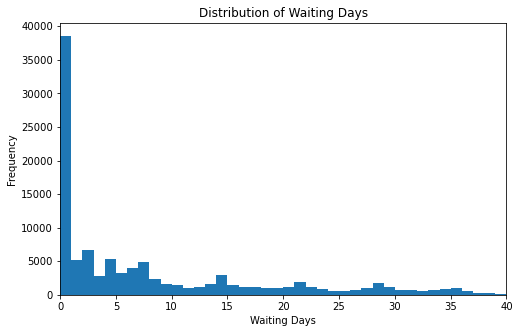

In [12]:
binsize = 1
bins = np.arange(0, no_show_app['waiting_days'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = no_show_app, x = 'waiting_days', bins = bins)
plt.xlim([0, 40])
plt.title('Distribution of Waiting Days')
plt.xlabel('Waiting Days')
plt.ylabel('Frequency')
plt.show();

## Distribution of Age

Age in the dataset takes values of 0 to 115. Age has a long-tailed distribution, with a lot of patients on the lower age end, and few on the higher age end, it seems to be multimodal with the highest peak around 0 and 2, After ward, there is a steep fall in frequency rather than a smooth ramp down.

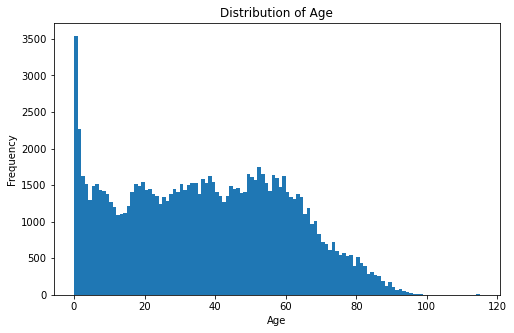

In [13]:
binsize = 1
bins = np.arange(0, no_show_app['age'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = no_show_app, x = 'age', bins = bins)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show();

## Waiting Days vs Age

There is a positive correlation between age and waiting days and also note that the count of patients decrease by waiting days and also decrease by age as it move. Which means the higher the age and waiting days the lower the patients frequency.

As the count of patients in the cell reduce the color in the heatmap gets brighter and moves from blue to yellow.

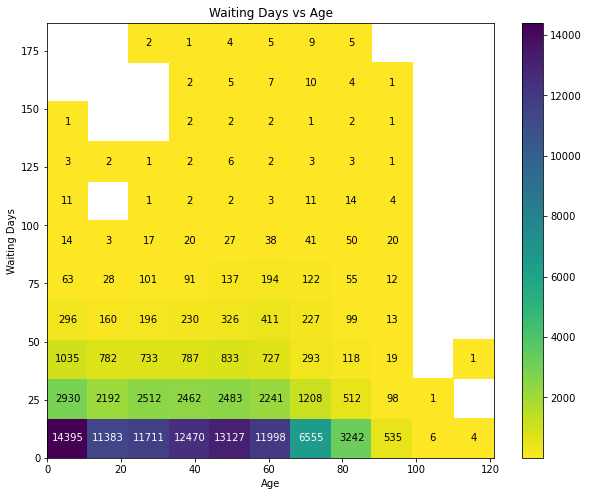

In [14]:
plt.figure(figsize=[10,8])
bins_x = np.arange(0, 115+11, 11)
bins_y = np.arange(0, 179+17, 17)

h2d = plt.hist2d(data = no_show_app, x = 'age', y = 'waiting_days',
                 cmin=0.5, cmap='viridis_r', bins = [bins_x, bins_y])

plt.colorbar()
plt.title("Waiting Days vs Age")
plt.xlabel('Age')
plt.ylabel('Waiting Days')

counts = h2d[0]

for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 3500: # increase visibility on darker cells
            plt.text(bins_x[i]+5.5, bins_y[j]+8.5, int(c),
                     ha = 'center', va = 'center', color = 'white')
        elif c > 0:
            plt.text(bins_x[i]+5.5, bins_y[j]+8.5, int(c),
                     ha = 'center', va = 'center', color = 'black')
plt.show();

## Waiting Days by No Show Variable

Waiting days by no show variable seems affect the decision of patients in showing up compare to other categorical variables. There are about 8 average days for patients who showed up compare to patients who doesn't show up with average days of 16.

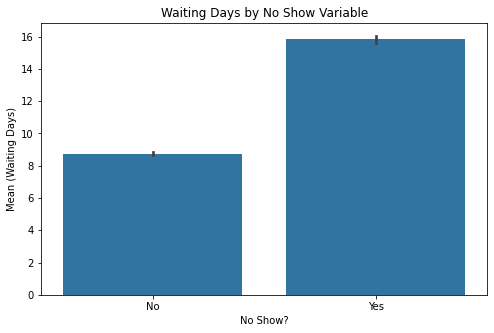

In [15]:
plt.figure(figsize=[8, 5])

sb.barplot(data=no_show_app, x='no_show', y='waiting_days', color=base_color)
plt.title('Waiting Days by No Show Variable')
plt.xlabel('No Show?')
plt.ylabel('Mean (Waiting Days)')
plt.show();

## Waiting Days by No_show and Gender

Even this still shows that the avearge waiting days of those who did not show up for their appointment by gender are still of the same value from the previous plot above falling between 15 and 16 average waiting days for both male and female.

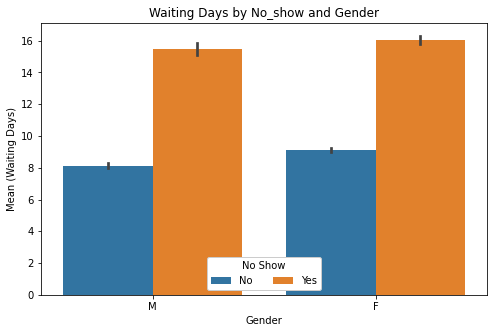

In [16]:
plt.figure(figsize=[8, 5])

ax = sb.barplot(data = no_show_app, x = 'gender', y = 'waiting_days', hue = 'no_show')
ax.legend(loc = 8, ncol = 3, framealpha = 1, title = 'No Show')
plt.title('Waiting Days by No_show and Gender')
plt.xlabel('Gender')
plt.ylabel('Mean (Waiting Days)')
plt.show();